## Import Libraries & Data

In [1]:
import os
import folium
import pandas as pd 
import geopandas as gpd
import matplotlib.pyplot as plt
from folium.features import GeoJsonTooltip
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Merged Rental History Feature Sets
one_bed_flat_merged = pd.read_csv('../data/curated/merged_feature_set/one_bed_flat_merged.csv')
two_bed_flat_merged = pd.read_csv('../data/curated/merged_feature_set/two_bed_flat_merged.csv')
three_bed_flat_merged = pd.read_csv('../data/curated/merged_feature_set/three_bed_flat_merged.csv')
two_bed_house_merged = pd.read_csv('../data/curated/merged_feature_set/two_bed_house_merged.csv')
three_bed_house_merged = pd.read_csv('../data/curated/merged_feature_set/three_bed_house_merged.csv')
four_bed_house_merged = pd.read_csv('../data/curated/merged_feature_set/four_bed_house_merged.csv')
all_properties_merged = pd.read_csv('../data/curated/merged_feature_set/all_properties_merged.csv')

## Get the Livability Index

In [68]:
# Get the columns that are relevant in determining livability

crime = test.filter(regex='^offence_division.*').columns
education_count = test.filter(regex='^(?!.*furnished).*_count$').columns
education_rank = test.filter(regex='.*_rank$').columns
distances = test.filter(regex='.*distance.*').columns

points_of_interest = ['park', 'cycleway', 'walking_paths', 'culture_and_leisure', 'financial_institutions', 
    'food_and_beverage','healthcare', 'public_facilities', 'shopping_and_retail','tourism_and_attractions',
    'accommodation', 'pofw count']

columns_to_normalize = list(crime) + list(education_count) + list(education_rank) + list(distances) + points_of_interest

def get_livability(df):

    # Initialize the scaler
    scaler = MinMaxScaler()

    df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])

    df[crime] = 1 - df[crime] # Crime should be negatively correlated with livability
    df[distances] = 1 - df[distances] # Larger distances to public transports, hospitals, cbd etc. are also negatively correlated with livability

    df['livability'] = (
        df[crime].sum(axis=1) +  
        df[education_count].sum(axis=1) + 
        df[education_rank].sum(axis=1) + 
        df[distances].sum(axis=1) +
        df[points_of_interest].sum(axis=1)
    )

    # Normalise to (0,1) scale
    df['livability'] = scaler.fit_transform(df[['livability']])

    return df[['year', 'suburb', 'livability']]

livability_one_bed_flat = get_livability(one_bed_flat_merged)
livability_two_bed_flat = get_livability(two_bed_flat_merged)
livability_three_bed_flat = get_livability(three_bed_flat_merged)

livability_two_bed_house = get_livability(two_bed_house_merged)
livability_three_bed_house = get_livability(three_bed_house_merged)
livability_four_bed_house = get_livability(four_bed_house_merged)

livability_all_properties = get_livability(all_properties_merged)

In [78]:
# Save livability data as csv's to merge with feature set
def save_livability_data():
    
    # Define the base path
    base_path = '../data/curated/livability'

    # Ensure the directory exists
    if not os.path.exists(base_path):
        os.makedirs(base_path)

    # Save each dataframe to a CSV file
    livability_one_bed_flat.to_csv(os.path.join(base_path, 'livability_one_bed_flat.csv'), index=False)
    livability_two_bed_flat.to_csv(os.path.join(base_path, 'livability_two_bed_flat.csv'), index=False)
    livability_three_bed_flat.to_csv(os.path.join(base_path, 'livability_three_bed_flat.csv'), index=False)
    livability_two_bed_house.to_csv(os.path.join(base_path, 'livability_two_bed_house.csv'), index=False)
    livability_three_bed_house.to_csv(os.path.join(base_path, 'livability_three_bed_house.csv'), index=False)
    livability_four_bed_house.to_csv(os.path.join(base_path, 'livability_four_bed_house.csv'), index=False)
    livability_all_properties.to_csv(os.path.join(base_path, 'livability_all_properties.csv'), index=False)

# Call the function
save_livability_data()

## Get Average Livability Index per Suburb

In [69]:
# Find the average livability index per suburb across years

average_livability_one_bed_flat = livability_one_bed_flat.groupby('suburb')['livability'].mean().reset_index()
average_livability_two_bed_flat = livability_two_bed_flat.groupby('suburb')['livability'].mean().reset_index()
average_livability_three_bed_flat = livability_three_bed_flat.groupby('suburb')['livability'].mean().reset_index()

average_livability_two_bed_house = livability_two_bed_house.groupby('suburb')['livability'].mean().reset_index()
average_livability_three_bed_house = livability_three_bed_house.groupby('suburb')['livability'].mean().reset_index()
average_livability_four_bed_house = livability_four_bed_house.groupby('suburb')['livability'].mean().reset_index()

average_livability_all_properties = livability_all_properties.groupby('suburb')['livability'].mean().reset_index()

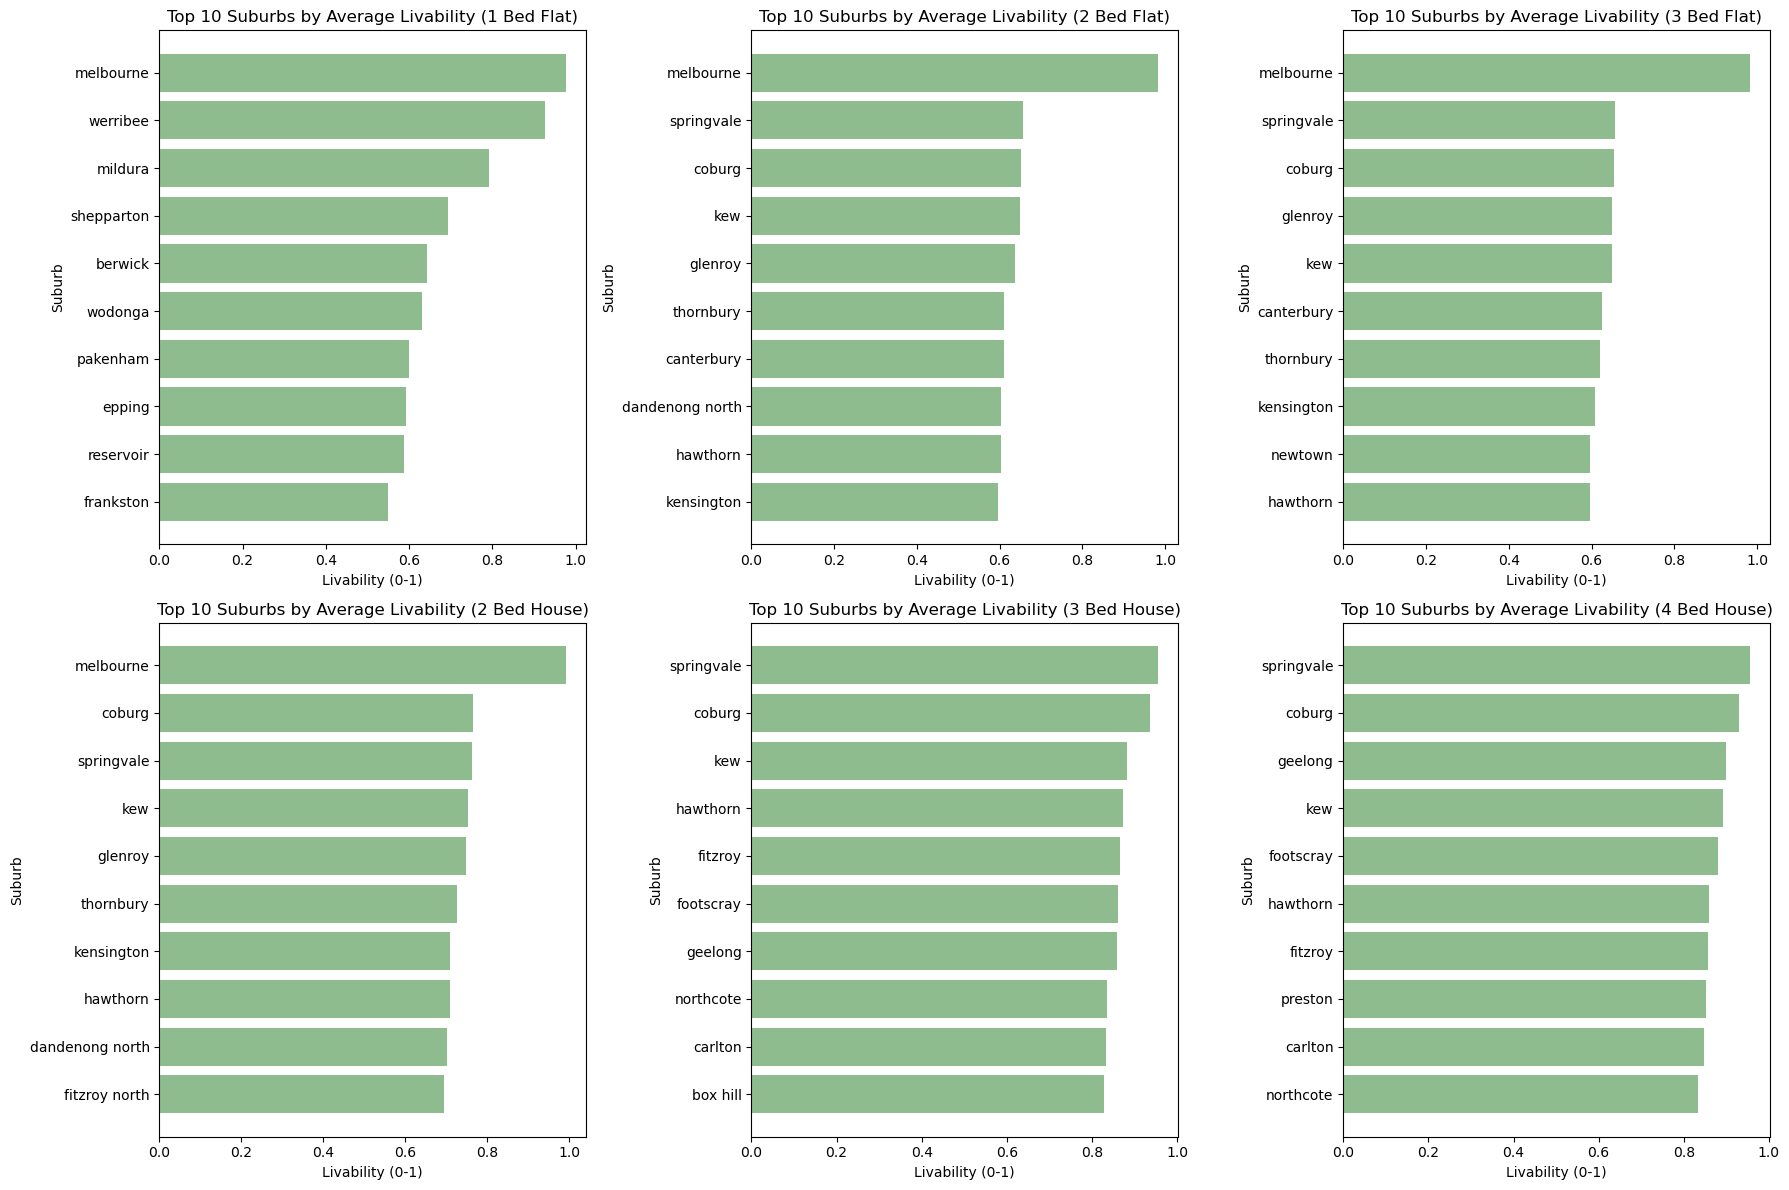

In [120]:
# Visualisations 

dataframes = [
    average_livability_one_bed_flat, 
    average_livability_two_bed_flat, 
    average_livability_three_bed_flat, 
    average_livability_two_bed_house, 
    average_livability_three_bed_house, 
    average_livability_four_bed_house, 
]

# Titles for each subplot
titles = [
    '1 Bed Flat', 
    '2 Bed Flat', 
    '3 Bed Flat', 
    '2 Bed House', 
    '3 Bed House', 
    '4 Bed House', 
]

fig, axes = plt.subplots(2, 3, figsize=(18, 12)) 
axes = axes.flatten()  # Flatten to 1D array to easily index each axis

# Loop through each DataFrame and plot it on a corresponding subplot
for i, df in enumerate(dataframes):

    # Sort the DataFrame by livability and select top 10 suburbs
    top_10 = df.sort_values(by='livability', ascending=False).head(10)

    # Plot the horizontal bar chart on the i-th axis
    axes[i].barh(top_10['suburb'], top_10['livability'], color='darkseagreen')

    # Add titles and labels
    axes[i].set_title(f'Top 10 Suburbs by Average Livability ({titles[i]})')
    axes[i].set_xlabel('Livability (0-1)')
    axes[i].set_ylabel('Suburb')

    # Invert the y-axis so the highest livability is at the top
    axes[i].invert_yaxis()

# Automatically adjust layout to avoid overlap
plt.tight_layout()

# Save the plot
plt.savefig("../plots/most_livable_suburbs.png")

# Display the plot
plt.show()


<function matplotlib.pyplot.show(close=None, block=None)>

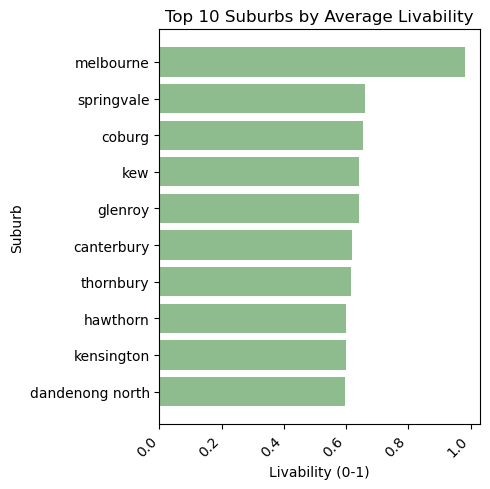

In [121]:
top_10_livability_all = average_livability_all_properties.sort_values(by='livability', ascending=False).head(10)

plt.figure(figsize=(5, 5))

plt.barh(top_10_livability_all['suburb'], top_10_livability_all['livability'], color = 'darkseagreen')

# Add titles and labels
plt.title('Top 10 Suburbs by Average Livability')
plt.xlabel('Livability (0-1)')
plt.ylabel('Suburb')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Invert the y-axis so the highest population is at the top
plt.gca().invert_yaxis()

# Display the bar chart
plt.tight_layout()
plt.savefig("../plots/most_livable_suburbs_all.png")
plt.show

In [86]:
vic_suburbs_gdf = gpd.read_file('../data/map/Vic_Localities/gda2020_vicgrid/esrishape/whole_of_dataset/victoria/VMADMIN/LOCALITY_POLYGON.shp')
vic_suburbs_gdf = vic_suburbs_gdf.to_crs(epsg=4326)
vic_suburbs_gdf['suburb'] = vic_suburbs_gdf['GAZLOC'].str.lower()

merged = pd.merge(average_livability_all_properties, vic_suburbs_gdf[['suburb', 'geometry']], on='suburb')

merged

,suburb,livability,geometry
0,abbotsford,0.324379,"POLYGON ((145.00235 -37.80722, 145.0035 -37.80..."
1,albert park,0.539532,"POLYGON ((144.9574 -37.84847, 144.95734 -37.84..."
2,alfredton,0.357517,"POLYGON ((143.8136 -37.55277, 143.81378 -37.55..."
3,alphington,0.529567,"POLYGON ((145.02868 -37.78721, 145.02855 -37.7..."
4,altona,0.414250,"POLYGON ((144.79085 -37.87026, 144.79111 -37.8..."
...,...,...,...
193,whittlesea,0.309258,"POLYGON ((145.21954 -37.46901, 145.21956 -37.4..."
194,williamstown,0.461811,"POLYGON ((144.9036 -37.861, 144.90361 -37.8610..."
195,windsor,0.510824,"POLYGON ((145.0021 -37.85497, 145.00199 -37.85..."
196,wodonga,0.359531,"POLYGON ((146.88878 -36.15021, 146.88828 -36.1..."


In [ ]:


m = folium.Map(location=[-37.8136, 144.9631], zoom_start=10, tiles="cartodb positron")

# Add the choropleth map for population with a better color scheme and highlight on hover
choropleth = folium.Choropleth(
    geo_data=merged_year.__geo_interface__,    # Geopandas dataframe in GeoJSON format
    data=merged_year,                          # Dataframe with population data
    columns=['sa2_name', 'erp'],               # Column to map (suburb names and population)
    key_on='feature.properties.suburb',        # Suburb name from GeoDataFrame (check this name)
    fill_color='YlOrRd',                       # Adjusted color scheme for better visual contrast
    fill_opacity=0.7,                          # Transparency of the color
    line_opacity=0.2,                          # Transparency of the borders
    highlight=True,                            # Enable highlighting when hovered
    legend_name=f'Population in {year_to_plot}' # Legend for the map
).add_to(m)

# Add tooltips to display suburb and population on hover
tooltip = GeoJsonTooltip(
    fields=['suburb', 'erp'],
    aliases=['Suburb:', 'Population:'],
    localize=True,
    sticky=False,
    labels=True,
    style="""
        background-color: #F0EFEF;
        border: 1px solid black;
        border-radius: 3px;
        box-shadow: 3px;
    """
)

# Apply the tooltip to the GeoJson layer
folium.GeoJson(
    merged_year.__geo_interface__,
    style_function=lambda feature: {
        'fillColor': 'transparent',
        'color': 'transparent',
        'weight': 0
    },
    tooltip=tooltip
).add_to(m)

# Add interactive elements like LayerControl
folium.LayerControl().add_to(m)

In [72]:
average_livability_all_properties.sort_values(by='livability', ascending=True).head(40)

,suburb,livability
127,morwell,0.008089
10,bairnsdale,0.035020
181,traralgon,0.109395
186,warragul,0.113786
146,ocean grove,0.132273
64,echuca,0.140937
110,lara,0.161942
57,deer park,0.163147
118,mildura,0.165200
63,dromana,0.171708


In [70]:
average_livability_all_properties.sort_values(by='livability', ascending=False).head(20)

,suburb,livability
115,melbourne,0.981211
170,springvale,0.660312
49,coburg,0.654508
108,kew,0.641159
86,glenroy,0.640357
36,canterbury,0.617558
178,thornbury,0.616032
94,hawthorn,0.601038
107,kensington,0.600785
56,dandenong north,0.597540


In [65]:
average_livability_one_bed_flat.sort_values(by='livability', ascending=False).head(20)

,suburb,livability
74,melbourne,0.981862
114,springvale,0.660893
35,coburg,0.652522
71,kew,0.642569
61,glenroy,0.641459
117,thornbury,0.614947
70,kensington,0.600474
64,hawthorn,0.588471
53,fitzroy north,0.584706
89,newtown,0.581198


In [63]:
livability_one_bed_flat.sort_values(by='livability', ascending=False).head(20)

,year,suburb,livability
875,2027,melbourne,1.000000
871,2023,melbourne,0.998033
874,2026,melbourne,0.996707
873,2025,melbourne,0.993386
869,2021,melbourne,0.992744
872,2024,melbourne,0.990123
870,2022,melbourne,0.990019
865,2017,melbourne,0.980939
867,2019,melbourne,0.976912
864,2016,melbourne,0.973341


In [52]:
test = one_bed_flat_merged.copy()

In [53]:
# Rank = 0 --> "NA"

crime = test.filter(regex='^offence_division.*').columns
education_count = test.filter(regex='^(?!.*furnished).*_count$').columns
education_rank = test.filter(regex='.*_rank$').columns
distances = test.filter(regex='.*distance.*').columns

points_of_interest = ['park', 'cycleway', 'walking_paths', 'culture_and_leisure', 'financial_institutions', 
    'food_and_beverage','healthcare', 'public_facilities', 'shopping_and_retail','tourism_and_attractions',
    'accommodation', 'pofw count']

In [ ]:
# columns for livability:
# offense_division_x (negative livability)

# Positive
# _count: 'primary_school_count', 'secondary_school_count', 'tertiary_institutions_count', 'total_education_count'
# _rank: 'avg_primary_school_rank', 'avg_secondary_school_rank'

# Positive
# 'park', 'cycleway', 'walking_paths', 
# 'culture_and_leisure', 'financial_institutions', 'food_and_beverage','healthcare', 'public_facilities', 'shopping_and_retail','tourism_and_attractions'
# 'accommodation', 'pofw count'

# Negatively correlated (further = less livable) (anything that contains distance)
# 'distance_to_fire_station', 'distance_to_hospital', 'distance_to_hotel','distance_to_kindergarten', 'distance_to_library', 'distance_to_mall',
# 'distance_to_park', 'distance_to_police', 'distance_to_restaurant','distance_to_supermarket', 'nearest_transport_avg_distance','distance_to_cbd',

In [ ]:
test[['pois_mode', 'pofw count', 'pofw mode',
       'distance_to_fire_station', 'distance_to_hospital', 'distance_to_hotel',
       'distance_to_kindergarten', 'distance_to_library', 'distance_to_mall',
       'distance_to_park', 'distance_to_police', 'distance_to_restaurant',
       'distance_to_supermarket', 'nearest_transport_avg_distance',
       'distance_to_cbd']]

In [54]:
from sklearn.preprocessing import MinMaxScaler

# Combine the columns that need to be normalized
columns_to_normalize = list(crime) + list(education_count) + list(education_rank) + list(distances) + points_of_interest

# Initialize the scaler
scaler = MinMaxScaler()

# Apply the scaler to the selected columns
test[columns_to_normalize] = scaler.fit_transform(test[columns_to_normalize])

In [46]:
from sklearn.preprocessing import StandardScaler

standard_scaler = StandardScaler()
test[columns_to_normalize] = standard_scaler.fit_transform(test[columns_to_normalize])

In [55]:
test[crime] = 1 - test[crime]
test[distances] = 1 - test[distances]

In [56]:
test['livability'] = (
    test[crime].sum(axis=1) +  # Crime is negatively correlated (already inverted)
    test[education_count].sum(axis=1) + 
    test[education_rank].sum(axis=1) + 
    test[distances].sum(axis=1) +  # Distances are negatively correlated (already inverted)
    test[points_of_interest].sum(axis=1)  # Points of interest positively correlated
)

test['livability'] = scaler.fit_transform(test[['livability']])

In [50]:
average_livability = test.groupby('suburb')['livability'].mean().reset_index()

top_10_livable_suburbs = average_livability.sort_values(by='livability', ascending=False).head(20)

top_10_livable_suburbs

,suburb,livability
74,melbourne,0.904390
71,kew,0.641279
35,coburg,0.636791
114,springvale,0.634246
64,hawthorn,0.612152
55,footscray,0.591505
117,thornbury,0.584674
53,fitzroy north,0.578307
75,mentone,0.576225
70,kensington,0.572777


In [43]:
test[crime].describe()

,offence_division_1,offence_division_2,offence_division_3,offence_division_4,offence_division_5,offence_division_6
count,1557.000000,1557.000000,1557.000000,1557.000000,1557.000000,1557.000000
mean,0.915683,0.921719,0.930721,0.959543,0.905016,0.986775
std,0.101307,0.084208,0.093938,0.070797,0.129234,0.044388
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.889735,0.900406,0.911147,0.952286,0.892813,0.989042
50%,0.947304,0.940727,0.957458,0.976977,0.953317,0.996819
75%,0.973195,0.965528,0.981691,0.989656,0.976658,0.998940
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [29]:
test[columns_to_normalize]

,offence_division_1,offence_division_2,offence_division_3,offence_division_4,offence_division_5,offence_division_6,primary_school_count,secondary_school_count,tertiary_institutions_count,total_education_count,...,walking_paths,culture_and_leisure,financial_institutions,food_and_beverage,healthcare,public_facilities,shopping_and_retail,tourism_and_attractions,accommodation,pofw count
0,0.971672,0.921385,0.959074,0.980314,0.984951,1.000000,0.166667,0.000000,0.000000,0.045455,...,0.055141,0.027457,0.111111,0.054945,0.054545,0.079051,0.099526,0.107143,0.032,0.235294
1,0.962230,0.924973,0.965536,0.976977,0.961302,1.000000,0.166667,0.000000,0.000000,0.045455,...,0.055141,0.027457,0.111111,0.054945,0.054545,0.079051,0.099526,0.107143,0.032,0.235294
2,0.973804,0.913820,0.952612,0.971972,0.964988,0.999293,0.166667,0.000000,0.000000,0.045455,...,0.055141,0.027457,0.111111,0.054945,0.054545,0.079051,0.099526,0.107143,0.032,0.235294
3,0.950959,0.922321,0.904146,0.961962,0.978808,0.998940,0.166667,0.000000,0.000000,0.045455,...,0.055141,0.027457,0.111111,0.054945,0.054545,0.079051,0.099526,0.107143,0.032,0.235294
4,0.960097,0.927624,0.918686,0.970304,0.977580,0.954401,0.166667,0.000000,0.000000,0.045455,...,0.055141,0.027457,0.111111,0.054945,0.054545,0.079051,0.099526,0.107143,0.032,0.235294
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1552,0.912275,0.940103,0.880452,0.972306,0.900184,0.988689,0.583333,0.285714,0.000000,0.363636,...,1.000000,0.589595,0.086420,0.051282,0.236364,0.158103,0.197472,0.053571,0.144,0.117647
1553,0.911362,0.941585,0.875606,0.972973,0.895577,0.987982,0.583333,0.285714,0.000000,0.363636,...,1.000000,0.589595,0.086420,0.051282,0.236364,0.158103,0.197472,0.053571,0.144,0.117647
1554,0.932074,0.984012,0.945073,0.977644,0.891892,0.990103,0.166667,0.285714,0.076923,0.181818,...,0.016998,0.053468,0.037037,0.016484,0.054545,0.027668,0.030016,0.273810,0.088,0.235294
1555,0.934816,0.987131,0.946150,0.979980,0.892199,0.989749,0.166667,0.285714,0.076923,0.181818,...,0.016998,0.053468,0.037037,0.016484,0.054545,0.027668,0.030016,0.273810,0.088,0.235294


In [30]:
test['livability'] = (
    test[crime].sum(axis=1) +  # Crime is negatively correlated (already inverted)
    test[education_count].sum(axis=1) + 
    test[education_rank].sum(axis=1) + 
    test[distances].sum(axis=1) +  # Distances are negatively correlated (already inverted)
    test[points_of_interest].sum(axis=1)  # Points of interest positively correlated
)

test['livability'] = scaler.fit_transform(test[['livability']])

In [59]:
average_livability.sort_values(by='livability', ascending=True).head(20)

,suburb,livability
82,morwell,0.007822
120,traralgon,0.100536
45,echuca,0.119601
95,ocean grove,0.134687
41,deer park,0.168873
76,mildura,0.169570
124,werribee,0.203019
73,malvern east,0.203790
106,sale,0.237310
78,moe,0.261312


In [58]:
average_livability = test.groupby('suburb')['livability'].mean().reset_index()

top_10_livable_suburbs = average_livability.sort_values(by='livability', ascending=False).head(20)

top_10_livable_suburbs

,suburb,livability
74,melbourne,0.981862
114,springvale,0.660893
35,coburg,0.652522
71,kew,0.642569
61,glenroy,0.641459
117,thornbury,0.614947
70,kensington,0.600474
64,hawthorn,0.588471
53,fitzroy north,0.584706
89,newtown,0.581198


In [41]:
test[test['livability'] > 0.5]['suburb'].unique()

array(['albert park', 'alphington', 'bendigo', 'box hill', 'brighton',
       'carlton', 'carlton north', 'chadstone', 'cheltenham', 'coburg',
       'collingwood', 'elsternwick', 'elwood', 'epping', 'fitzroy',
       'fitzroy north', 'footscray', 'geelong', 'geelong west', 'glenroy',
       'greensborough', 'hawthorn', 'hoppers crossing', 'kensington',
       'kew', 'malvern', 'melbourne', 'mentone', 'mordialloc',
       'newborough', 'newcomb', 'newtown', 'noble park',
       'north melbourne', 'northcote', 'oakleigh', 'preston', 'richmond',
       'south melbourne', 'south yarra', 'springvale', 'thornbury',
       'toorak', 'wendouree', 'west melbourne', 'windsor', 'yarraville',
       'ferntree gully'], dtype=object)

In [39]:
test['livability'].describe()

count    1557.000000
mean        0.444234
std         0.125990
min         0.000000
25%         0.382900
50%         0.453693
75%         0.523645
max         1.000000
Name: livability, dtype: float64

In [33]:
test[test['suburb'] == 'frankston']

,suburb,year,dec_median,jun_median,mar_median,sep_median,offence_division_1,offence_division_2,offence_division_3,offence_division_4,...,distance_to_supermarket,nearest_transport_avg_distance,distance_to_cbd,median_bath,median_parkings,furnished_count,unfurnished_count,pets_allowed,pets_not_allowed,livability
648,frankston,2016,220.0,220.0,220.0,220.0,0.670423,0.699189,0.724825,0.740741,...,0.321211,0.982089,0.903957,1,0,0,15,1,14,17.035783
649,frankston,2017,230.0,230.0,225.0,225.0,0.671946,0.741148,0.763059,0.777778,...,0.321211,0.982089,0.903957,1,0,0,15,1,14,17.177831
650,frankston,2018,240.0,235.0,235.0,240.0,0.631739,0.717439,0.761982,0.777110,...,0.321211,0.982089,0.903957,1,0,0,15,1,14,17.085619
651,frankston,2019,250.0,250.0,240.0,250.0,0.697533,0.716269,0.719440,0.766767,...,0.321211,0.982089,0.903957,1,0,0,15,1,14,17.075997
652,frankston,2020,240.0,240.0,249.0,240.0,0.667073,0.775542,0.630048,0.789790,...,0.321211,0.982089,0.903957,1,0,0,15,1,14,16.884400
653,frankston,2021,250.0,250.0,245.0,250.0,0.734085,0.812666,0.719440,0.808475,...,0.321211,0.982089,0.903957,1,0,0,15,1,14,17.411820
654,frankston,2022,280.0,260.0,255.0,265.0,0.708803,0.789034,0.777060,0.821154,...,0.321211,0.982089,0.903957,1,0,0,15,1,14,17.293470
655,frankston,2023,310.0,300.0,300.0,310.0,0.652757,0.744112,0.755520,0.847181,...,0.321211,0.982089,0.903957,1,0,0,15,1,14,17.071622
656,frankston,2024,320.0,320.0,320.0,330.0,0.697228,0.797613,0.735057,0.848849,...,0.321211,0.982089,0.903957,1,0,0,15,1,14,17.215957
657,frankston,2025,NaN,NaN,NaN,NaN,0.701493,0.808298,0.736134,0.861862,...,0.321211,0.982089,0.903957,1,0,0,15,1,14,17.236009


In [32]:
test[test['suburb'] == 'melbourne']

,suburb,year,dec_median,jun_median,mar_median,sep_median,offence_division_1,offence_division_2,offence_division_3,offence_division_4,...,distance_to_supermarket,nearest_transport_avg_distance,distance_to_cbd,median_bath,median_parkings,furnished_count,unfurnished_count,pets_allowed,pets_not_allowed,livability
864,melbourne,2016,395.0,390.0,385.0,390.0,0.090466,0.000312,0.378029,0.052052,...,0.626444,0.985164,0.998075,1,0,130,217,16,331,23.073490
865,melbourne,2017,420.0,400.0,400.0,415.0,0.081328,0.000000,0.264405,0.032366,...,0.626444,0.985164,0.998075,1,0,130,217,16,331,23.144529
866,melbourne,2018,430.0,420.0,420.0,425.0,0.095340,0.132819,0.143780,0.000000,...,0.626444,0.985164,0.998075,1,0,130,217,16,331,22.931796
867,melbourne,2019,450.0,448.0,440.0,450.0,0.131892,0.075963,0.101239,0.084751,...,0.626444,0.985164,0.998075,1,0,130,217,16,331,23.106882
868,melbourne,2020,350.0,425.0,450.0,400.0,0.193421,0.200593,0.000000,0.366033,...,0.626444,0.985164,0.998075,1,0,130,217,16,331,22.686442
869,melbourne,2021,300.0,320.0,330.0,310.0,0.173317,0.336453,0.196554,0.454788,...,0.626444,0.985164,0.998075,1,0,130,217,16,331,23.254918
870,melbourne,2022,400.0,340.0,320.0,365.0,0.021322,0.182499,0.108778,0.243911,...,0.626444,0.985164,0.998075,1,0,130,217,16,331,23.229440
871,melbourne,2023,520.0,479.0,450.0,500.0,0.000000,0.083684,0.302639,0.378378,...,0.626444,0.985164,0.998075,1,0,130,217,16,331,23.304375
872,melbourne,2024,550.0,550.0,550.0,530.0,0.064270,0.246061,0.120086,0.468802,...,0.626444,0.985164,0.998075,1,0,130,217,16,331,23.230410
873,melbourne,2025,NaN,NaN,NaN,NaN,0.056655,0.272656,0.105008,0.528195,...,0.626444,0.985164,0.998075,1,0,130,217,16,331,23.260923


In [ ]:
test[crime] = 1 - test[crime]
test[distances] = 1 - test[distances]

In [4]:
test.columns

Index(['suburb', 'year', 'dec_median', 'jun_median', 'mar_median',
       'sep_median', 'offence_division_1', 'offence_division_2',
       'offence_division_3', 'offence_division_4', 'offence_division_5',
       'offence_division_6', 'hi_1_149_tot', 'hi_150_299_tot',
       'hi_300_399_tot', 'hi_400_499_tot', 'hi_500_649_tot', 'hi_650_799_tot',
       'hi_800_999_tot', 'hi_1000_1249_tot', 'hi_1250_1499_tot',
       'hi_1500_1749_tot', 'hi_1750_1999_tot', 'hi_2000_2499_tot',
       'hi_2500_2999_tot', 'hi_3000_3499_tot', 'hi_3500_3999_tot',
       'hi_4000_more_tot', 'erp', 'primary_school_count',
       'secondary_school_count', 'tertiary_institutions_count',
       'avg_primary_school_rank', 'avg_secondary_school_rank',
       'has_primary_school', 'has_secondary_school', 'total_education_count',
       'commercial_areas', 'farmland', 'forest', 'industrial_areas',
       'nature_reserve', 'park', 'residential_areas', 'retail_areas',
       'landuse_mode', 'cycleway', 'main_roads', 'mo